=== Part A: Original El Farol ===
Mean attendance (last 100): 36.00

=== Part B: Discrete-probability RL ===
Mean attendance (last 20): 37.05
Mean chosen p (last 20): 0.751


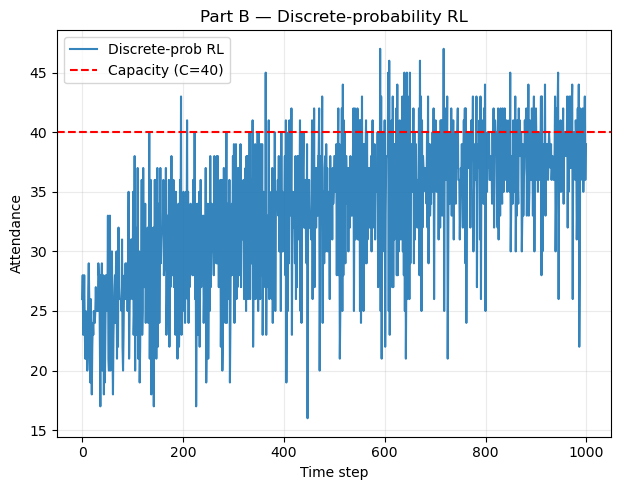

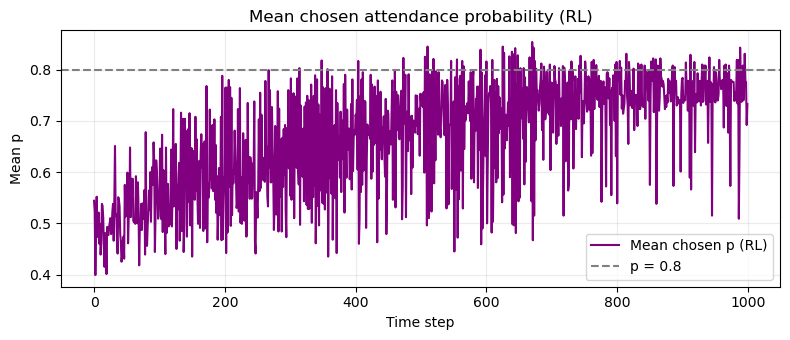

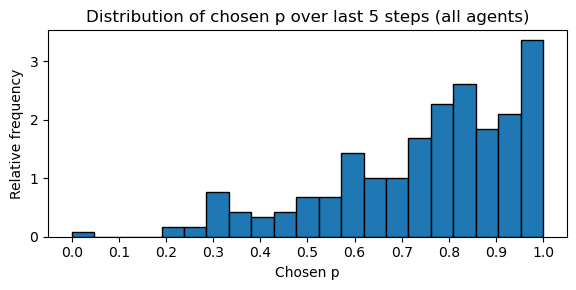

In [88]:
"""
El Farol Bar Problem — Two Simple Implementations

Part A: "Original" El Farol (Arthur-style predictors).
Part B: Discrete-probability Reinforcement Learning (tabular Q-learning).

"""

import random, math
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# PARAMETERS (clear and editable)
# ---------------------------------------------------------------------
# Common
SEED = 420
np.random.seed(SEED)
random.seed(SEED)

# Game / environment
N = 50            # number of agents
C_frac = 0.8      # capacity as fraction of population
C = int(C_frac * N)  # bar capacity
T = 1000         # number of rounds / time steps

# Payoffs
G = 8.0   # payoff for attending when not overcrowded
S = 2.0   # payoff for staying home
F = 0.1   # payoff for attending when overcrowded

# Theta / punishment parameters (Part B)
rho = 0.6 #PREV 0.1
alpha = 1.8 #PREV 1.3
theta_cap = 1000
bar_theta = 1.1
beta = 0.5  

# RL parameters (Part B)
M = 20          # discretization steps: actions = 0..M (p = a/M) there will be M+1 many probability levels cus also 0
LR = 0.01       # Q-learning rate - to high learning rate means that convergens happens too quicly and all of the space in the bar might not be utilized
GAMMA = 0.7     # discount factor
TAU = 0.1      # softmax temperature
K_INIT = 0.1    # initial Q value range
# ---------------------------------------------------------------------


# -------------------------
# Discrete-probability RL
# -------------------------
def softmax(x, tau=TAU):
    #Boltzmann (softmax) policy, which converts Q-values into action probabilities - x is vector of q-values (consites of action and state)
    z = x / tau
    z -= np.max(z) #just numerical stability
    expz = np.exp(z) # Exponential weighting
    return expz / expz.sum() #Normalization constant (sum over all actions)


def bin_theta(theta):
    #Binning θ turns a continuous, potentially huge variable into a small, learnable categorical feature that makes Q-learning practical and stable.
    """Binning for Theta - maps the order of magnitude of theta to an integer “bin”"""
    if theta <= 0:
        return 0
    return min(int(math.log10(theta + 1e-9) + 1), 6) # ensures that the Q-tables has a discrete and hashable keys


def make_state(A):
    """State representation"""
    a_int = int(A)
    return (a_int)


def run_discrete_prob_rl(N=N, C=C, T=T, M=M, lr=LR, gamma=GAMMA, tau=TAU,
                         rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT):
    """Discrete-probability RL model"""
    Q_tables = [dict() for _ in range(N)] #makes N dicts - each maps the discreate state representet as a Q-vector of length M+1.
    last_actual = np.random.binomial(1, 0.5, size=N) #It represents the previous actions (attendance) of the agents before the simulation begins (i put 50/50)
    theta_i = np.array([bar_theta if a == 0 else 0.0 for a in last_actual], dtype=float) #if agent’s initial action was 0, set theta = bar_theta, else 0.0 for all the N actions in last_actual.
    Theta = theta_i.sum() #just the sum used for payoff

    def q_get(qdict, s):
        #Returns the Q-vector for state s stored in qdict (an agent’s Q-table).
        #If s is absent, initializes a new random Q-vector uniformly in [0, k_init) of length M+1.

        #q_get initialises Q-values randomly in [0, k_init). This introduces stochasticity and exploration early on.

        if s not in qdict:
            qdict[s] = np.random.uniform(0, k_init, size=M + 1)
        return qdict[s]

    attendance_ts = [] #(list of attendance counts over time),
    mean_p_ts = [] #(mean of chosen probabilities each timestep),
    chosen_action_counts = np.zeros((N, M + 1), dtype=int) #(N x (M+1) counts of how many times each index chosen),
    chosen_history = np.zeros((T, N), dtype=int)  # (T x N array storing chosen indices each time step) KINDA BIG.

    attendance_var_ts = [] #new: create list of varianses
    avg_payoff_ts = []              # NEW: track average payoff each timestep
    all_payoffs = np.zeros((T, N))  # NEW: record individual payoffs each timestep

    for t in range(T):
        #THE LOOP BEGINS 
        A_prev = attendance_ts[-1] if t > 0 else int(N * 0.1) #previous attendance (use 10% of N as initial attendance at t=0). WHY 0.1
        state = make_state(A_prev) #RETURNS PREVIAUS STATE AS INTEGER AND THETA (JUST BINED)

        actions = np.zeros(N, dtype=int)
        chosen_idxs = np.zeros(N, dtype=int)

        for i in range(N): # for each player
            qvec = q_get(Q_tables[i], state) #get state representation for player i aka their q-table in a givn state ( stat consisting of prev atendens and theta)
            probs = softmax(qvec, tau=tau) #softmax converts Q-values into a categorical distribution over indices 0..M. Temperature tau controls exploration vs exploitation
            idx = np.random.choice(np.arange(M + 1), p=probs) #idx is the chosen discrete index; stored in chosen_idxs[i] and increments chosen_action_counts[i, idx]. 
            # idx is a random choice, but weighted by the current Q-values. It’s not purely random; it’s probabilistic action selection guided by the learned Q-values.
            chosen_idxs[i] = int(idx)
            chosen_action_counts[i, idx] += 1

        p_vec = chosen_idxs / float(M) #The chosen index is mapped to a probability p = idx / M
        #the intended probability of taking the actual action = 1. Then the agent actually samples action ~ Bernoulli(p).

        for i in range(N):
            actions[i] = np.random.binomial(1, p_vec[i]) #Then action (0 or 1) is sampled for each agent with that probability P.

        chosen_history[t, :] = chosen_idxs  # stores the chosen discrete index for each agent each time step.

        A_t = actions.sum() #SUM OF ACTIONS ALSO ATENTES CUZ 1 AND 0 ARE NICE TO WORK WITH
        attendance_ts.append(A_t) #attendance counts over time (sum of binary actions) USED TO PLOT 
        mean_p_ts.append(p_vec.mean()) #average of the p_vec across agents each timestep.

        attendance_var_ts.append(float(np.var(actions))) #new: add varians of the actions/attendance 
        

        # Update theta
        new_theta = np.zeros_like(theta_i)

        for i in range(N): # for all players:
            # If agent did not go now (action==0) and also did not go previously (last_actual==0): 
            # theta increases from prev by rho * prev**alpha, capped by theta_cap. 
            # If prev was 0, it uses bar_theta as starting value. HELP
            if actions[i] == 0 and last_actual[i] == 0:
                prev = theta_i[i] if theta_i[i] > 0 else bar_theta
                new_val = prev + rho * (prev ** alpha)
                new_theta[i] = min(new_val, theta_cap)
            elif actions[i] == 0 and last_actual[i] == 1:
                #If agent did not go now but went previously (last_actual==1), reset theta to bar_theta
                new_theta[i] = bar_theta
            else:
                #If agent just went (action==1), set theta to 0.
                new_theta[i] = 0.0
        theta_i = new_theta #why - I dont get the shape why is it not inside loop i am confution CANT JUST GO INTO REWARD EITHER --> Sad
        Theta = float(theta_i.sum())

        # Rewards
        rewards = np.zeros(N, dtype=float)
        for i in range(N):
            if actions[i] == 1:
                # If an agent chooses to go, payoff depends on how many other agents chose to go:
                # If others < C → payoff = G.
                # If others >= C → payoff = F.
                others = A_t - 1
                payoff = G if others < C else F
            else:
                #If agent chooses 0, payoff is S
                payoff = S
            rewards[i] = payoff - beta * theta_i[i] #PLAY with theta - i tried with new_theta[i] but that just destroys the learning

        # Record average payoff and store payoffs for histogram later

        avg_payoff_ts.append(rewards.mean())   # mean payoff at this timestep
        all_payoffs[t, :] = rewards            # save payoffs of all agents at time t


        next_state = make_state(A_t)
        for i in range(N):
            #the actual q-learning 
            qdict = Q_tables[i] #is the agent’s personal Q-table - The key is the current environment state - The value is the vector of Q-values for all possible discrete actions (M+1 of them).
            qvec = q_get(qdict, state)
            next_qvec = q_get(qdict, next_state)
            aidx = chosen_idxs[i] #this is player i's current indet (could also just be p*M and thik of M as 100 even when it isnt)
            r = rewards[i]
            qvec[aidx] += lr * (r + gamma * np.max(next_qvec) - qvec[aidx]) #Standard one-step Q-learning update: Q(s, a) ← Q(s, a) + α [ r + γ max_a' Q(s', a') − Q(s, a) ].
            qdict[state] = qvec #Q-table is updated in-place in Q_tables[i][state]. aka store the updated Q-values qvec for this particular state in the agent’s Q-table
            # the q values can be thought of as: what the agent has learned about which idx (probability of acting) works best in each state. where the state is represented as the atendence as well as the size of theta

        last_actual = actions.copy() #Each last_actual[i] indicates whether agent i was “attending” (1) or “not attending” (0) at the previous time step (t = -1).
        # the .copy just allows you to put new actions next time step and then save them agian ones you are dome

    return {
        "attendance_ts": np.array(attendance_ts),
        "mean_p_ts": np.array(mean_p_ts),
        "chosen_action_counts": chosen_action_counts,
        "chosen_history": chosen_history,
        "final_theta": theta_i,
        "final_Q_tables": Q_tables,
        "attendance_var_ts": np.array(attendance_var_ts),   # NEW
        "avg_payoff_ts": np.array(avg_payoff_ts),    # NEW
        "all_payoffs": np.array(all_payoffs)         # NEW
        
    }


# -------------------------
# Run both models and plot
# -------------------------
if __name__ == "__main__":
    print("=== Part A: Original El Farol ===")
    att_el = run_el_farol_predictors()
    print(f"Mean attendance (last 100): {att_el[-100:].mean():.2f}")

    print("\n=== Part B: Discrete-probability RL ===")

    res = run_discrete_prob_rl(N=N, C=C, T=T, M=M, lr=LR, gamma=GAMMA, tau=TAU,
                         rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT)
    
    
    att_rl = res["attendance_ts"]
    mean_p = res["mean_p_ts"]
    print(f"Mean attendance (last 20): {att_rl[-20:].mean():.2f}")
    print(f"Mean chosen p (last 20): {mean_p[-20:].mean():.3f}")

    # ---- PLOTS ----
    plt.figure(figsize=(12, 5))
    #plt.subplot(1, 2, 1)
    #plt.plot(att_el, label="Original El Farol", alpha=0.9)
    #plt.axhline(C, color='r', linestyle='--', label=f'Capacity (C={C})')
    #plt.title("Part A — Original El Farol (Predictors)")
    #plt.xlabel("Time step")
    #plt.ylabel("Attendance")
    #plt.legend()
    #plt.grid(True, alpha=0.25)

    plt.subplot(1, 2, 2)
    plt.plot(att_rl, label="Discrete-prob RL", alpha=0.9)
    plt.axhline(C, color='r', linestyle='--', label=f'Capacity (C={C})')
    plt.title("Part B — Discrete-probability RL")
    plt.xlabel("Time step")
    plt.ylabel("Attendance")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Mean chosen probability (RL)
    plt.figure(figsize=(8, 3.5))
    plt.plot(mean_p, label='Mean chosen p (RL)', color='purple')
    plt.axhline(C_frac, color='gray', linestyle='--', label=f'p = {C_frac}')
    plt.title("Mean chosen attendance probability (RL)")
    plt.xlabel("Time step")
    plt.ylabel("Mean p")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Histogram: distribution of chosen p's in final window
    chosen_hist = res["chosen_history"]
    final_window = 5 # do spisific numbers to see what happens at what times in the learning
    M = chosen_hist.max()
    w = min(final_window, chosen_hist.shape[0])
    flat_idxs = chosen_hist[-w:, :].flatten()
    p_values = flat_idxs / M

    plt.figure(figsize=(6, 3))
    plt.hist(p_values, bins=M + 1, edgecolor='black', density=True)
    plt.title(f"Distribution of chosen p over last {w} steps (all agents)")
    plt.xlabel("Chosen p")
    plt.ylabel("Relative frequency")
    plt.xticks(np.linspace(0, 1, 11))
    plt.tight_layout()
    plt.show()


Mean attendance (last 20): 36.15
Mean chosen p (last 20): 0.710


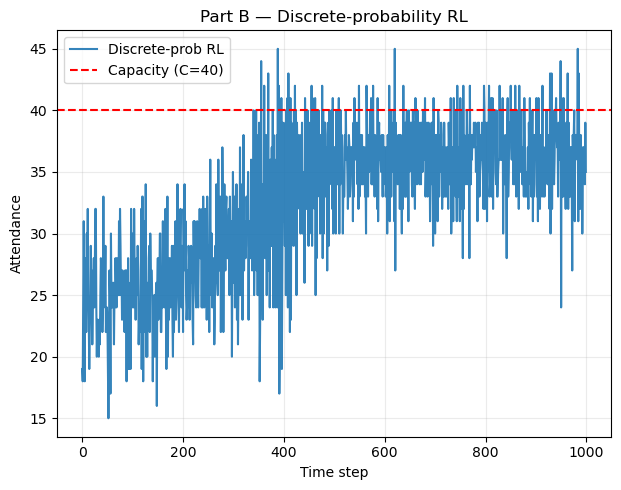

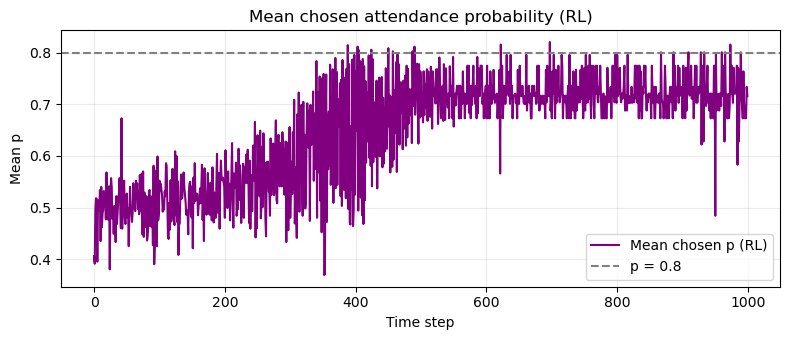

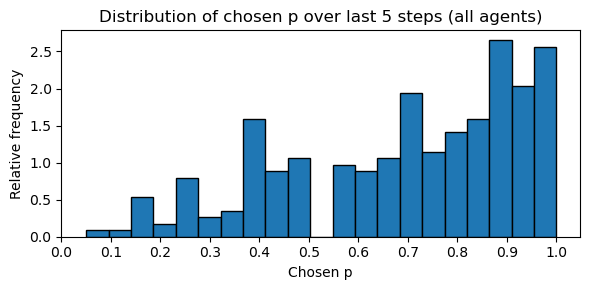

In [91]:
# --- Temperature schedule parameters ---
TAU_START = 1.0      # initial exploration temperature
TAU_MIN = 0.001       # minimal exploration
TAU_DECAY = 0.01    # decay rate

def run_discrete_prob_rl(N=N, C=C, T=T, M=M, lr=LR, gamma=GAMMA,
                         tau_start=TAU_START, tau_min=TAU_MIN,
                         rho=rho, alpha=alpha, beta=beta,
                         bar_theta=bar_theta, theta_cap=theta_cap, k_init=K_INIT):
    """
    Discrete-probability RL (instrumented).
    - Returns tau_history so you can verify decay.
    - Uses global Theta for the -beta * Theta penalty (consistent with earlier versions).
    - Computes TAU_DECAY so tau reaches tau_min by timestep T (approx).
    """
    Q_tables = [dict() for _ in range(N)]
    last_actual = np.random.binomial(1, 0.5, size=N)
    theta_i = np.array([bar_theta if a == 0 else 0.0 for a in last_actual], dtype=float)
    #Theta = float(theta_i.sum())

    def q_get(qdict, s):
        if s not in qdict:
            qdict[s] = np.random.uniform(0, k_init, size=M + 1)
        return qdict[s]

    attendance_ts = []
    mean_p_ts = []
    chosen_action_counts = np.zeros((N, M + 1), dtype=int)
    chosen_history = np.zeros((T, N), dtype=int)

    attendance_var_ts = []
    avg_payoff_ts = []
    all_payoffs = np.zeros((T, N))

    # Compute decay rate so tau(T-1) ≈ tau_min
    if tau_min <= 0 or tau_start <= 0:
        raise ValueError("tau_start and tau_min must be > 0")
    
    TAU_DECAY = -math.log(tau_min / tau_start) / max(1, (T - 1))

    tau_history = []



    for t in range(T):
        tau_t = max(tau_min, tau_start * math.exp(-TAU_DECAY * t))
        tau_history.append(tau_t)

        A_prev = attendance_ts[-1] if t > 0 else int(N * 0.1)
        state = make_state(A_prev)

        actions = np.zeros(N, dtype=int)
        chosen_idxs = np.zeros(N, dtype=int)

        for i in range(N):
            qvec = q_get(Q_tables[i], state)
            probs = softmax(qvec, tau=tau_t)
            # quick sanity: probs sum ~1, no NaNs
            if np.any(np.isnan(probs)) or probs.sum() <= 0:
                # fallback to uniform if numerical issue
                probs = np.ones(M + 1) / (M + 1)
            idx = np.random.choice(np.arange(M + 1), p=probs)
            chosen_idxs[i] = int(idx)
            chosen_action_counts[i, idx] += 1


        p_vec = chosen_idxs / float(M)

        for i in range(N):
            actions[i] = np.random.binomial(1, p_vec[i])

        chosen_history[t, :] = chosen_idxs

        A_t = actions.sum()
        attendance_ts.append(A_t)
        mean_p_ts.append(p_vec.mean())
        attendance_var_ts.append(float(np.var(actions)))

        # Update theta (unchanged)
        new_theta = np.zeros_like(theta_i)
        for i in range(N):
            if actions[i] == 0 and last_actual[i] == 0:
                prev = theta_i[i] if theta_i[i] > 0 else bar_theta
                new_val = prev + rho * (prev ** alpha)
                new_theta[i] = min(new_val, theta_cap)
            elif actions[i] == 0 and last_actual[i] == 1:
                new_theta[i] = bar_theta
            else:
                new_theta[i] = 0.0
        theta_i = new_theta
        Theta = float(theta_i.sum())

        # Rewards
        rewards = np.zeros(N, dtype=float)
        for i in range(N):
            if actions[i] == 1:
                others = A_t - 1
                payoff = G if others < C else F
            else:
                payoff = S
            rewards[i] = payoff - beta * theta_i[i]

        avg_payoff_ts.append(float(rewards.mean()))
        all_payoffs[t, :] = rewards

        # Q-learning update
        next_state = make_state(A_t)
        for i in range(N):
            qdict = Q_tables[i]
            qvec = q_get(qdict, state)
            next_qvec = q_get(qdict, next_state)
            aidx = chosen_idxs[i]
            r = rewards[i]
            qvec[aidx] += lr * (r + gamma * np.max(next_qvec) - qvec[aidx])
            qdict[state] = qvec

        last_actual = actions.copy()

    return {
        "attendance_ts": np.array(attendance_ts),
        "mean_p_ts": np.array(mean_p_ts),
        "chosen_action_counts": chosen_action_counts,
        "chosen_history": chosen_history,
        "final_theta": theta_i,
        "final_Q_tables": Q_tables,
        "attendance_var_ts": np.array(attendance_var_ts),
        "avg_payoff_ts": np.array(avg_payoff_ts),
        "all_payoffs": np.array(all_payoffs),
        "tau_history": np.array(tau_history)
    }

    


# -------------------------
# Models and plots
# -------------------------
if __name__ == "__main__":

    res = run_discrete_prob_rl(N=N, C=C, T=T, M=M, lr=LR, gamma=GAMMA, 
                               tau_start=TAU_START, tau_min=TAU_MIN,
                         rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT)
    
    
    att_rl = res["attendance_ts"]
    mean_p = res["mean_p_ts"]
    print(f"Mean attendance (last 20): {att_rl[-20:].mean():.2f}")
    print(f"Mean chosen p (last 20): {mean_p[-20:].mean():.3f}")

    # ---- PLOTS ----
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 2)
    plt.plot(att_rl, label="Discrete-prob RL", alpha=0.9)
    plt.axhline(C, color='r', linestyle='--', label=f'Capacity (C={C})')
    plt.title("Part B — Discrete-probability RL")
    plt.xlabel("Time step")
    plt.ylabel("Attendance")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Mean chosen probability (RL)
    plt.figure(figsize=(8, 3.5))
    plt.plot(mean_p, label='Mean chosen p (RL)', color='purple')
    plt.axhline(C_frac, color='gray', linestyle='--', label=f'p = {C_frac}')
    plt.title("Mean chosen attendance probability (RL)")
    plt.xlabel("Time step")
    plt.ylabel("Mean p")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Histogram: distribution of chosen p's in final window
    chosen_hist = res["chosen_history"]
    final_window = 5 # do spisific numbers to see what happens at what times in the learning
    M = chosen_hist.max()
    w = min(final_window, chosen_hist.shape[0])
    flat_idxs = chosen_hist[-w:, :].flatten()
    p_values = flat_idxs / M

    plt.figure(figsize=(6, 3))
    plt.hist(p_values, bins=M + 1, edgecolor='black', density=True)
    plt.title(f"Distribution of chosen p over last {w} steps (all agents)")
    plt.xlabel("Chosen p")
    plt.ylabel("Relative frequency")
    plt.xticks(np.linspace(0, 1, 11))
    plt.tight_layout()
    plt.show()



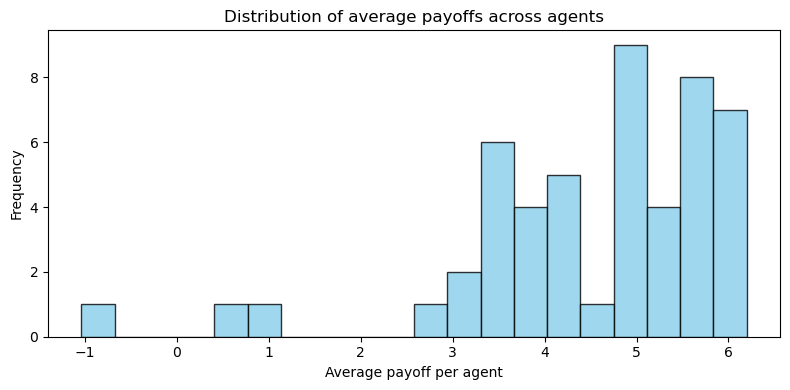

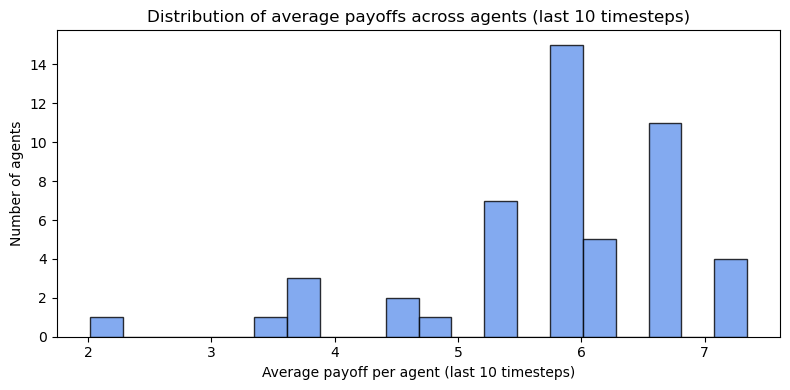

In [79]:
# Compute each agent’s average payoff over the full run
agent_avg_payoffs = res["all_payoffs"].mean(axis=0)

plt.figure(figsize=(8, 4))
plt.hist(agent_avg_payoffs, bins=20, color="skyblue", edgecolor="black", alpha=0.8)
plt.xlabel("Average payoff per agent")
plt.ylabel("Frequency")
plt.title("Distribution of average payoffs across agents")
plt.tight_layout()
plt.show()


# --- Compute average payoff across the last 10 timesteps for each agent ---
last_window = 10  # number of final timesteps to average
last_10_avg_payoffs = res["all_payoffs"][-last_window:, :].mean(axis=0)

# --- Plot: Histogram of average payoffs across agents (last 10 timesteps) ---
plt.figure(figsize=(8, 4))
plt.hist(last_10_avg_payoffs, bins=20, color="cornflowerblue", edgecolor="black", alpha=0.8)
plt.xlabel("Average payoff per agent (last 10 timesteps)")
plt.ylabel("Number of agents")
plt.title("Distribution of average payoffs across agents (last 10 timesteps)")
plt.tight_layout()
plt.show()